# Llama_tutorial

- Corrective RAG Agent


### 0. Settings

In [ ]:
# !pip install -U langchain langgraph langsmith langchain_experimental langchain_core langchain_ollama Ipython faiss-cpu torchvision sentence-transformers langchain_huggingface tavily-python

In [38]:
# !pip freeze > /Users/hyojuuun/Documents/GitHub/LangGraph_Ollama/requirments.txt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [14]:
import os
from dotenv import load_dotenv

def langsmith(project_name=None, set_enable=True):
    load_dotenv()

    if set_enable:
        result = os.environ.get("LANGCHAIN_API_KEY")
        if result is None or result.strip() == "":
            print(
                "LangChain API Key가 설정되지 않았습니다."
            )
            return
        os.environ["LANGCHAIN_ENDPOINT"] = (
            "https://api.smith.langchain.com"  # LangSmith API 엔드포인트
        )
        os.environ["LANGCHAIN_TRACING_V2"] = "true"  # true: 활성화
        os.environ["LANGCHAIN_PROJECT"] = project_name  # 프로젝트명
        print(f"LangSmith 추적을 시작합니다.\n[프로젝트명]\n{project_name}")
    else:
        os.environ["LANGCHAIN_TRACING_V2"] = "false"  # false: 비활성화
        print("LangSmith 추적을 하지 않습니다.")

In [15]:
langsmith("Llama_Tutorial")

LangSmith 추적을 시작합니다.
[프로젝트명]
Llama_Tutorial


In [16]:
import warnings

# 경고 메시지 무시
warnings.filterwarnings("ignore")

In [17]:
PATH_DATA = os.getenv('PATH_DATA')
PATH_VECTORSTORE = os.getenv('PATH_VECTORSTORE')

### 1. Vector Store

- load local vector store

In [12]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

# Define the path to your vectorstore
vectorstore_path = PATH_VECTORSTORE + 'faiss_gte_base_FT'

# Load the embedding model from Hugging Face
model_name = 'hyojuuun/gte_base_MIMICCXR_FT'
embeddings = HuggingFaceEmbeddings(model_name=model_name)

# Load the FAISS vectorstore from disk
vectorstore = FAISS.load_local(
    vectorstore_path,
    embeddings,
    allow_dangerous_deserialization=True
)

# Create a retriever from the vectorstore
retriever = vectorstore.as_retriever(search_kwargs={"k": 1})

### 2. Web Search Tool

In [33]:
from langchain_community.tools.tavily_search import TavilySearchResults

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
web_search_tool = TavilySearchResults(k=1)

### 3. Llama3.1 

In [24]:
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers.string import StrOutputParser
from langchain_ollama import ChatOllama

# PromptTemplate 수정: input_variables를 리스트로 변경
prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks.

    Use the following documents to answer the question.

    If you don't know the answer, just say that you don't know.

    Use three sentences maximum and keep the answer concise:
    Question: {question}
    Documents: {documents}
    Answer:
    """,
    input_variables=["question", "documents"] # 리스트로 변경
)

# LLM 인스턴스 생성
llm = ChatOllama(
    model="llama3.1",
    temperature=0
)

# StrOutputParser를 인스턴스화하고 체인 생성
rag_chain = prompt | llm | StrOutputParser()

### 4. Retrieval Grader

In [25]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser

# JSON
llm = ChatOllama(
    model='llama3.1',
    format='json',
    temperature=0
)

prompt = PromptTemplate(
    template="""You are an grader assesing relevance of the retrieved document to a user question. \n
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: \n\n {question} \n\n
    If the document contains keywords related to the user question, grade is as relevant. \n
    It does not need to be a stringest test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.
    """, 
    input_variables={"document", "question"}
)

retrieval_grader = prompt | llm | JsonOutputParser()

### 5. LangGraph

In [31]:
from typing import TypedDict, List
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langchain.schema import Document

class GraphState(TypedDict):
    """
    Represents the state of our graph
    
    Attributes:
        question: question
        generation: LLM generation
        search: whether to add search
        documents: list of documents
    """
    
    question: str
    generation: str
    search: str
    documents: List[str]
    steps: List[str]
    
def retrieve(state: GraphState):
    """
    Retrieves documents
    
    Args:
        state (dict): The current graph state
        
    Returns:
        state (dict): New key added to state, documents, that contains the retrieved documents
    """
    
    question = state["question"]
    documents = retriever.invoke(question)
    steps = state['steps']
    steps.append("retrieve_documents")
    return {"documents": documents, "question": question, "steps": steps}
    
def generate(state: GraphState):
    """
    Generate answer
    
    Args:
        state (dict): The current graph state
    
    Returns:
        state (dict): New key added to state, generation, that contains the LLM generation
    """
    
    question = state["question"]
    documents = state['documents']
    generation = rag_chain.invoke({"documents": documents, "question": question})
    steps = state["steps"]
    steps.append("generate_answer")
    return {
        "documents": documents, 
        "question": question, 
        "generation": generation, 
        "steps": steps
    }

def grade_documents(state: GraphState):
    """
    Determines whether the retrieved documents are relevant to the question.
    
    Args:
        state (dict): The current graph state
        
    Returns:
        state (dict): Updates documents key with onlt filtered relevant documents
    """
    
    question = state["question"]
    documents = state["documents"]
    steps = state["steps"]
    steps.append("grade_documents_retrieval")
    filtered_docs = []
    search = "No"
    for doc in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": doc.page_content}
        )
        grade = score["score"]
        if grade == "Yes":
            filtered_docs.append(doc)
        else:
            search = "Yes"
            continue
    return {
        "documents": filtered_docs, 
        "question": question,
        "search": search, 
        "steps": steps
    }
    
def web_search(state: GraphState):
    """
    Web search based on the re-phrased question
    
    Args:
        state (dict): The current graph state
    
    Returns:
        state (dict): Updates documents key with appended web results
    """
    
    question = state["question"]
    documents = state.get("documents", [])
    steps = state["steps"]
    steps.append("web_search")
    web_results = web_search_tool.invoke({"query": question})
    documents.extend(
        [
            Document(page_content=doc['content'], metadata={"url": doc["url"]})
            for doc in web_results
        ]
    )
    return {
        "documents": documents, 
        "question": question, 
        "steps": steps
    }
    
def decide_to_generate(state: GraphState):
    """ 
    Determines whether to generate an answer or re-generate a question.
    
    Args:
        staet (dict): The current graph state
    
    Returns:
        str: Binary decision for next node to call
    """
    
    search = state["search"]
    if search == "Yes":
        return "search"
    else:
        return "generate"

### 6. Graph Construction

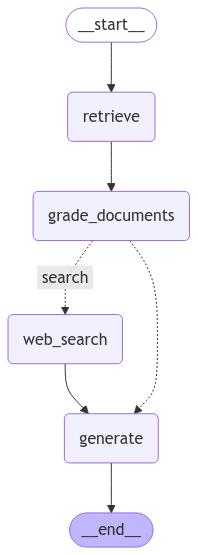

In [27]:
# Graph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)
workflow.add_node("generate", generate)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("web_search", web_search)

# Define the edges
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate, 
    {
        "search": "web_search", 
        "generate": "generate"
    }
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

custom_graph = workflow.compile()

display(Image(custom_graph.get_graph(xray=True).draw_mermaid_png()))

### 7. Execution

In [32]:
import uuid

def predict_custom_agent_answer(example: dict):
    
    config = {"configureable": {"thread_id": str(uuid.uuid4())}}
    
    state_dict = custom_graph.invoke(
        {"question": example["input"], "steps": []}, config
    )
    
    return {"response": state_dict["generation"], "steps": state_dict["steps"]}

example = {"input": "What is the capital of France?"}
response = predict_custom_agent_answer(example)
print(response)
    

{'response': 'The capital of France is Paris. This information can be found on multiple documents, including Wikipedia articles about Paris and France\'s geography. The city has been referred to as the "City of Light" due to its adoption of gas lighting and its role in the Age of Enlightenment.', 'steps': ['retrieve_documents', 'grade_documents_retrieval', 'web_search', 'generate_answer']}


### 8. Evaluation

In [ ]:
from langchain import hub

# Grade prompt
grade_prompt_answer_accuracy = hub.pull("langchain-ai/rag-answer-vs-reference")

def anser_evaluator(run, example) -> dict:
    """
    A simple evaluator for RAG answer accuracy
    """
    
    # Get the question, the ground truth reference answer, RAG chain answer prediction
    input_question = exmaple.inputs['input']
    reference = example.outputs['output']
    prediction = run.outputs["response"]
    
    # Define an LLM grader
    llm = ChatOpenAI(model="gpt-4o", temperature=0)
    answer_grader = grade_prompt_answer_accuracy | llm
    
    # Run evaluator
    score = answer_grader.invoke(
        {
            "question": input_question, 
            "correct_answer": reference, 
            "student_answer": prediction,
        }
    )
    score = score["Score"]
    return {"key": "answer_vs_reference_score", "score": score}

##### 8-1. Custom Evaluation

In [ ]:
from langsmith import Example, Run

# Reasoning traces that we expect the agents to take
expected_trajectory_1 = [
    "retrieve_documents", 
    "grade_documents_retrieval", 
    "web_search", 
    "generate_answer"
]

expected_trajectory_2 = [
    "retrieve_documents", 
    "grade_documents_retrieval", 
    "generate_answer"
]

def check_trajectory_custom(root_run: Run, example: Example) -> dict:
    """
    Check if all expected tools are called in exact order and without any additional tool calls.
    """
    
    tool_calls = root_run.outputs["steps"]
    print(f"Tool calls custom agent: {tool_calls}")
    if tool_calls == expected_trajectory_1 or tool_calls == expected_trajectory_2:
        score = 1
    else:
        score = 0
    
    return {"score": int(score), "key": "tool_calls_in_exact_order"}

### 9. Create Langsmith Dataset

In [ ]:
from langsmith import Client

client = Client()

# Create a dataset
examples = [
    (
        "How does the ReAct agent use self-reflection?", 
        "ReAct integrates reasoning and acting, performing actions - such tools like Wikipedia search API"
    ), 
    (
        # more examples...
    )
]

# Save it
dataset_name = "Corrective RAG Agent Testing"
if not client.has_dataset(dataset_name=dataset_name):
    dataset = client.create_dataset(dataset_name=dataset_name)
    inputs, outputs = zip(
        *[({"input": text}, {"output":label}) for text, label in examples]
    )
    client.create_examples[inputs=inputs, outputs=outputs, dataset_id=dataset.id]

### 10. Run Evaluation

In [ ]:
from langsmith.evaluation import evaluate

dataset_name = "Corrective RAG Agent Testing"
model_tested = "llama3.1"
metadata = "CRAG, llama3.1"
experiment_prefix = f"custom-agent-{model_tested}"
experiment_results = evaluate(
    predict_custom_agent_answer, 
    data=dataset_name, 
    evaluator=[answer_evaluator, check_trajectory_custom],
    experiment_prefix=experiment_prefix + "-answer-and-tool-use",
    num_repetitions=3, 
    metadata={"version": metadata}
)